In this demo we show how to use XGboost (eXtreme Gradient Boosting) on a test dataset. First we train and evaluate the vanilla model, then we use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from scikit.learn to explore the hyperparameter space. If the hyperparameter space becomes too big we can also consider using [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

Reference material is:

* [official documentation](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)
* [paperspace tutorial](https://blog.paperspace.com/xgboost-a-comprehensive-guide-to-model-overview-analysis-and-code-demo-using/
)
* [a colab tutorial](https://colab.research.google.com/github/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/notebooks/Machine-Learning-with-XGBoost-solution.ipynb) (which runs up to a point)

A reminder on XGboost:

> In this algorithm, decision trees are created sequentially and weights play a major role in XGBoost. In this approach, each independent variable is initially assigned weights and input into a decision tree for prediction. Variables predicted incorrectly by the tree receive increased weights and are subsequently used in a second decision tree. These individual classifiers then combine to create a robust and more accurate model through ensemble learning.


In [1]:
# Set the random seed for reproducibility
import numpy as np
np.random.seed(42)

# Demo data

In [2]:
# Demo data: ad click info
import pandas as pd
url="https://raw.githubusercontent.com/ataislucky/Data-Science/main/dataset/ad_ctr.csv"
ad_data = pd.read_csv(url)

print(ad_data)

      Daily Time Spent on Site   Age  Area Income  Daily Internet Usage  \
0                        62.26  32.0     69481.85                172.83   
1                        41.73  31.0     61840.26                207.17   
2                        44.40  30.0     57877.15                172.83   
3                        59.88  28.0     56180.93                207.17   
4                        49.21  30.0     54324.73                201.58   
...                        ...   ...          ...                   ...   
9995                     41.73  31.0     61840.26                207.17   
9996                     41.73  28.0     51501.38                120.49   
9997                     55.60  39.0     38067.08                124.44   
9998                     46.61  50.0     43974.49                123.13   
9999                     46.61  43.0     60575.99                198.45   

                               Ad Topic Line             City  Gender  \
0            Decentralized

In [3]:
# The list of features with their type
print(ad_data.dtypes)

Daily Time Spent on Site    float64
Age                         float64
Area Income                 float64
Daily Internet Usage        float64
Ad Topic Line                object
City                         object
Gender                       object
Country                      object
Timestamp                    object
Clicked on Ad                 int64
dtype: object


Feature conversion, engineering

In [4]:
# Removing unwanted columns
ad_data.drop(['Ad Topic Line','City','Timestamp'],axis=1, inplace=True)

# Transforming string columns to categorical
ad_data['Gender'] = ad_data['Gender'].astype('category')
ad_data['Country'] = ad_data['Country'].astype('category')

# Define what is our target feature
X = ad_data.loc[:, ad_data.columns != 'Clicked on Ad']
y = ad_data['Clicked on Ad']

# Split train/validation sets
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=45)

# Printing the shapes, just to be sure
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((8000, 6), (2000, 6), (8000,), (2000,))

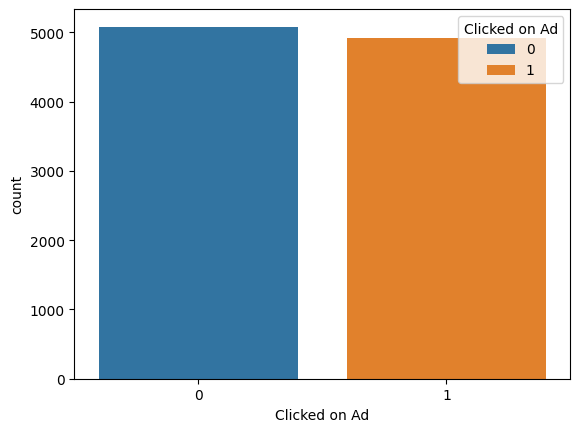

In [5]:
#bar plot to visualize the target variable
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='Clicked on Ad',data=ad_data, hue = 'Clicked on Ad')
plt.show()

# XGBoost, basic

In [6]:
# Importing xgboost library for python (luckily it's already installed)
import xgboost as xgb

# The default classifier. We need to specify that "enable_categorical" is
# true so that it takes into account the categorical variables defined above
# (otherwise it just spits an error)
model_1 = xgb.XGBClassifier(enable_categorical = True)
model_1 = model_1.fit(X_train, y_train)

# Predicting the validation set
y_pred = model_1.predict(X_val)

# Evaluating the performances
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_val, y_pred))

Accuracy:  0.844


# Missingness

To show that XGboost can handle missing data points we are going to inject 10% of NANs into the training set at random points.

In [14]:
# A copy of the train data, which will receive 10% of missings
X_train_missing = X_train.copy()

# How many cells should we remove?
n_total = X_train_missing.size
n_missing = int(np.floor(0.1 * n_total))

# Flatten the (row, col) indices, so to obtain a list of [(0, 0), (0, 1), (0, 2), (0, 3), ....]
all_indices = [(row, col) for row in range(X_train_missing.shape[0]) for col in range(X_train_missing.shape[1])]

# Picking missing indices
missing_indices = np.random.choice(len(all_indices), n_missing, replace=False)

# For each missing index we put a nan
for i in missing_indices:
    row, col = all_indices[i]
    X_train_missing.iat[row, col] = np.nan

# Check that we actually injected the missing data points
missing_cnt = X_train_missing.isna().sum().sum()
size_cnt = X_train_missing.size
print(f"Total missing data points: {missing_cnt} / {size_cnt} ({100.0 * missing_cnt / size_cnt:.2f}%)")

Total missing data points: 4800 / 48000 (10.00%)


In [8]:
# Training XGBoost on the dataset with missing data points
model_m = xgb.XGBClassifier(enable_categorical = True)
model_m = model_m.fit(X_train_missing, y_train)

# Predicting the validation set
y_pred = model_m.predict(X_val)

# Evaluating the performances
acc_m = accuracy_score(y_val, y_pred)
print("Accuracy (missing points): ", acc_m)

# For comparison, the old model trained on the full dataset
y_pred = model_1.predict(X_val)
acc_1 = accuracy_score(y_val, y_pred)
print("Accuracy (full dataset)  : ", acc_1)

# Computing the lost accuracy
print(f"Change: {100*(acc_m-acc_1)/acc_1:.2f} %")

Accuracy (missing points):  0.844
Accuracy (full dataset)  :  0.844
Change: 0.00 %


# Hyperparameter tuning



In [9]:
# This is the space of hyperparameters we are going to explore
PARAMETERS = {"subsample":[0.5, 0.75, 1],
"colsample_bytree":[0.5, 0.75, 1],
"max_depth":[2, 6, 12],
"min_child_weight":[1,5,15],
"learning_rate":[0.3, 0.1, 0.03],
"n_estimators":[100]}

from sklearn.model_selection import GridSearchCV

model = xgb.XGBClassifier(n_estimators=100, enable_categorical=True, n_jobs=-1, eval_metric='error')
model_gs = GridSearchCV(model,param_grid=PARAMETERS,cv=3,scoring="accuracy")

In [10]:
# Wall clocking the execution time. You can compare using CPU and GPU
import time
start = time.time()
model_gs.fit(X_train,y_train)
end = time.time()
print("Time required for exploring the hyperparameter space [sec]:", end - start)

Time required for exploring the hyperparameter space [sec]: 240.39970541000366


In [11]:
# Let' take a look to the best hyperparameter combination
print(model_gs.best_params_)

{'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.75}


In [12]:
# Initialise a new model using the best parameters
model_2 = xgb.XGBClassifier(
  enable_categorical = True,
  subsample=0.75,
  colsample_bytree=0.5,
  min_child_weight=1,
  max_depth=12,
  learning_rate=0.1,
  n_estimators=100)

# Fit the model
model_2 = model_2.fit(X_train, y_train)

In [13]:
# Predicting the validation set with the new model
y_pred = model_2.predict(X_val)
acc_2 = accuracy_score(y_val, y_pred)
print("Accuracy model 2: ", acc_2)

# For comparison, the old model without hyperparameter tuning
y_pred = model_1.predict(X_val)
acc_1 = accuracy_score(y_val, y_pred)
print("Accuracy model 1: ", acc_1)

# Computing the improvement
print(f"Change: {100*(acc_2-acc_1)/acc_1:.2f} %")

Accuracy model 2:  0.8545
Accuracy model 1:  0.844
Change: 1.24 %
